In [2]:
import numpy as np
import time
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

# CIFAR10 classification



#1: Data set

First, we load the dataset.

In [12]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular CIFAR10 dataset.
(train_images,train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

We then investigate the dataset to see in what format the loaded data comes and how we might want/need to preprocess it.

In [13]:
# access the shape of an array 'arr' with 'arr.shape'
# use 'np.max', 'np.min' to access the maximum or minimum of an array
# get the string info about labels via the tfds.builder functionality
print('Shape of training images: ' + str(train_images.shape))
print('Shape of training labels: ' + str(train_labels.shape))
print('Shape of testing images: ' + str(test_images.shape))
print('Shape of testing labels: ' + str(test_labels.shape))
print('Data type of labels: ' + str(test_labels[0].dtype))
print('Pixel value range : [' + str(np.min(train_images[0])) + ',' + str(np.max(train_images[0])) + ']')
# access class label names
builder = tfds.builder('cifar10')
info = builder.info
# store class labels and corresponding names in a dictionary
labels = list(set(train_labels.reshape((-1,))))
str_labels = []
for i in labels:
  str_labels.append(info.features["label"].int2str(i))
label_dict = dict(zip(labels,str_labels))
print('Class labels and names: ' + str(label_dict))

Shape of training images: (50000, 32, 32, 3)
Shape of training labels: (50000, 1)
Shape of testing images: (10000, 32, 32, 3)
Shape of testing labels: (10000, 1)
Data type of labels: uint8
Pixel value range : [0,255]
Class labels and names: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


**It is always important to understand the format and the count of the data you are dealing with.**  

*How many training/test images does this dataset have?*  
50000 training images, 10000 test images

*Which shape do the images have?*
32 times 32 pixels

*Which data type do the labels have?*
Integer values (uint8)

*In which range are the pixel values?*  
colored (=3 channels for each image) from 0 to 255

### Visualize the dataset.


We take a look at a few samples of the (training) dataset to *see* what we are dealing with.


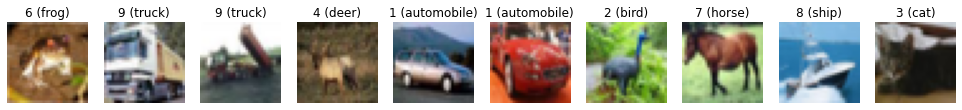

In [14]:
# Plot 10 samples with their corresponding label.
fig, ax = plt.subplots(1,10, figsize=(17,4))
for i in range(10):
    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels.reshape(-1,)[i]
    name_lbl = (label_dict[lbl])

    ax[i].imshow(img)
    ax[i].set_title(str(lbl) + " (" + name_lbl + ")")
    ax[i].axis("off")

### Build the TensorFlow dataset: Input pipeline
Next comes our preprocessing. We normalize the input (center pixel values around zero), one-hot encode the target class labels, batch and shuffle our final datasets for training and test data, respectively.

In [15]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels.reshape((-1,)))
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels.reshape((-1,)))

# center around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))

# zip together input and labels 
train_dataset_centered = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
test_dataset_centered = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))

# Shuffle, batch and prefetch data
train_dataset_centered = train_dataset_centered.shuffle(buffer_size=64).batch(64).prefetch(64)
test_dataset_centered = test_dataset_centered.shuffle(buffer_size=64).batch(64).prefetch(64)

# print shape of exemplary data
train_dataset_centered.take(1)

<TakeDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

We will not make use of data augmentation, but the following code would enable us to include/generate transformed images by using the "datagen" object in the training loop:

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#2: Model
We implemented a CNN Architecture with some additional features.
In order to help the network learn and generalize better on unseen data, prevent from overfitting and the vanishing/exploding gradient problems, we make use of the following optimization techniques:

* **$l_2$ regularization** for the weights to penalize large values, we can then later access the regularization losses as "model.losses" in the training loop to add it to our task loss
* we use **dropout** layers in between layers to keep all neurons engaged during training, avoiding that only a fraction that learned some random detail leading to correct decisions by chance takes over the complete task
* **batch normalization** to normalize the drives of neurons

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()

        self.activation_relu = tf.keras.activations.relu

        self.dropout_p2 = tf.keras.layers.Dropout(.2)
        self.dropout_p3 = tf.keras.layers.Dropout(.3)
        self.dropout_p4 = tf.keras.layers.Dropout(.4)

        weight_decay = 1e-4


        # Layer 1
        self.conv_1 = tf.keras.layers.Conv2D(filters=32,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()

        self.activation_relu_1 = tf.keras.layers.Activation(self.activation_relu)


        # Layer 2

        self.conv_2 = tf.keras.layers.Conv2D(filters=32,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        
        self.activation_relu_2 = tf.keras.layers.Activation(self.activation_relu)

        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))


        # Layer 3

        self.conv_3 = tf.keras.layers.Conv2D(filters=64,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        
        self.activation_relu_3 = tf.keras.layers.Activation(self.activation_relu)


        # Layer 4

        self.conv_4 = tf.keras.layers.Conv2D(filters=64,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        
        self.activation_relu_4 = tf.keras.layers.Activation(self.activation_relu)

        self.max_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        # Layer 5

        self.conv_5 = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_5 = tf.keras.layers.BatchNormalization()
        
        self.activation_relu_5 = tf.keras.layers.Activation(self.activation_relu)

        
        # Layer 6

        self.conv_6 = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=3,
                                             padding='same',
                                             activation=None,
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
                                             )
        
        self.batch_norm_6 = tf.keras.layers.BatchNormalization()
        
        self.activation_relu_6 = tf.keras.layers.Activation(self.activation_relu)

        self.max_pool_6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        

        # flatten the feature maps
        self.flatten_layer = tf.keras.layers.Flatten()


        # output dense layer for the 10 different categories
        self.output_layer = tf.keras.layers.Dense(10,
                                                  activation=tf.keras.activations.softmax
                                                  )
    @tf.function
    # training boolean: indicator whether to apply dropout or not, True when training, False when testing
    def call(self, x, training=True):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.batch_norm_1(x, training)
        x = self.activation_relu_1(x)
        x = self.conv_2(x)
        x = self.batch_norm_2(x, training)
        x = self.activation_relu_2(x)
        x = self.max_pool_2(x)
        x = self.dropout_p2(x, training)


        x = self.conv_3(x)
        x = self.batch_norm_3(x, training)
        x = self.activation_relu_3(x)
        x = self.conv_4(x)
        x = self.batch_norm_4(x, training)
        x = self.activation_relu_4(x)
        x = self.max_pool_4(x)
        x = self.dropout_p3(x, training)

        x = self.conv_5(x)
        x = self.batch_norm_5(x, training)
        x = self.activation_relu_5(x)
        x = self.conv_6(x)
        x = self.batch_norm_6(x, training)
        x = self.activation_relu_6(x)
        x = self.max_pool_6(x)
        x = self.dropout_p4(x, training)

        x = self.flatten_layer(x)
        
        x = self.output_layer(x)
        return x

# 3 & 4: Training and Visualization
Having done all necessary preprocessing steps on the data and defined our model, we only have to implement the training and testing procedure and a visualization function until we can finally start running our model on the data to see how it performs.

First, we define training and test functions.

In [18]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input,training=True)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  
  for (input, target) in test_data:
    prediction = model(input,training=False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Next, we define the following function to work in the  visualization of losses and accuracies during training and testing into our training loop, so we can check on our network's progress while training.

In [19]:
def visualize(test_losses, train_losses, test_accuracies, train_accuracies):
  """This method first clears the output of the cell and then print out 2 plots. One for the test and training loop and one for the test accuracy.
  When called in a for loop it kind of animates the progress within the for loop."""
  display.clear_output(wait=True)
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
  fig.suptitle('Training')
  ax1.title.set_text("Loss for training and test data")
  ax1.plot(test_losses, label='Test losses')
  ax1.plot(train_losses, label='Train losses')
  ax1.legend()
  ax1.grid()

  ax2.title.set_text("Performance on test data :" + str(round(test_accuracies[-1] * 100, 2)) + "%\n Performance on training data :"+ str(round(train_accuracies[-1] * 100, 2)) + "%")
  ax2.plot(test_accuracies, label='Test accuracy')
  ax2.plot(train_accuracies, label='Train accuracy')
  ax2.legend()
  ax2.grid()
  plt.show()

(Nearly) Done! Now we only have to set some Hyperparameters (training steps, learning rate, ...), say which loss function and optimizer for the parameter updates we want to use, initialize our model and make use of what we worked out previously(training, testing and visualization functions) in our training loop to see how everything works.

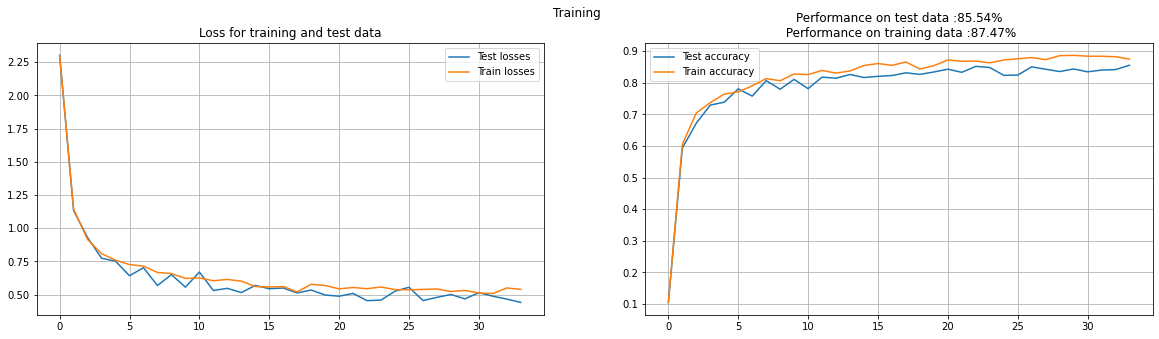

Elapsed time:  1048.9s 

Currently running epoch: __ 34


In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 50
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the Model.
model = Model()
# Initialize the loss: Categorical Crossentropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: RMSprop 
optimizer = tf.keras.optimizers.RMSprop(learning_rate, decay=1e-7)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
start = time.time()

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset_centered, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print("Accuracy on test data before any training: ", test_accuracy)
print("Loss on test data before any training: ", test_loss, "\n")

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset_centered, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Currently running epoch: __ ' + str(epoch + 1))

    train_dataset_centered = train_dataset_centered.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_centered = test_dataset_centered.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)


    #training (and checking in with training)
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset_centered:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)
    # glimpse at performance during training
    # print('Training accuracy: ' + str(train_accuracies[-1]))

    #testing
    test_loss, test_accuracy = test(model, test_dataset_centered, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # glimpse at performance after training, on test data
    # print('Test accuracy: ' + str(test_accuracies[-1]))
    
    # glimpse at performance after training, on test data
    visualize(test_losses, train_losses, test_accuracies, train_accuracies)
    print('Elapsed time:  '+ str(round((time.time() - start), 2)) + 's \n')

In [ ]:
# final visualization
figg, axx = plt.subplots(figsize=(12,6))
axx.plot(test_accuracies[0:], label='Test Accuracies')
axx.plot(train_accuracies[0:], label='Train Accuracies')
plt.hlines(0.85, xmin=0, xmax=len(train_accuracies), colors='r', label='85%')
plt.vlines(np.where(np.asarray(test_accuracies)>=0.85)[0][0], 0.75, 0.875, color='g', label='First >=85%')
plt.xticks(range(len(train_accuracies)), range(0, len(train_accuracies)+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
axx.grid(animated=True)
axx.legend(loc='upper left')
plt.show()

In [ ]:
# model summary with no. parameters per layer and in total
model.summary()

# Playground

Here one can make changes to see how using different preprocessing steps / model architectures / training parameters influence performance.
**Comments indicate where changes might be made.**

Execute all cells (also those without comments) to make sure you have everything set up as before or also in case you start the session here freshly.

In [ ]:
import time
import numpy as np
from IPython import display
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
(train_images,train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels.reshape((-1,)))
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels.reshape((-1,)))
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))
train_dataset_centered = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
test_dataset_centered = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
train_dataset_centered = train_dataset_centered.shuffle(buffer_size=64).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_centered = test_dataset_centered.shuffle(buffer_size=64).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input,training=True)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy

def test(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = [] 
  for (input, target) in test_data:
    prediction = model(input,training=False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)
  return test_loss, test_accuracy

In [ ]:
def visualize(test_losses, train_losses, test_accuracies, train_accuracies):
  display.clear_output(wait=True)
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
  fig.suptitle('Training')
  ax1.title.set_text("Loss for training and test data")
  ax1.plot(test_losses, label='Test losses')
  ax1.plot(train_losses, label='Train losses')
  ax1.legend()
  ax1.grid()
  ax2.title.set_text("Performance on test data :" + str(round(test_accuracies[-1] * 100, 2)) + "%\n Performance on training data :"+ str(round(train_accuracies[-1] * 100, 2)) + "%")
  ax2.plot(test_accuracies, label='Test accuracy')
  ax2.plot(train_accuracies, label='Train accuracy')
  ax2.legend()
  ax2.grid()
  plt.show()

### We present an exemplary alternative architecture (less maxpooling, other dropout rates, optional: additional dense layers before the output layer) in the following. Feel free to make changes to it.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers. You can define new layers/change the existing ones and
        # use a completely different architecture (as long as the propagated data can be processed through every layer).
        # The output layer should remain a dense layer with 10 units and softmax activation(as required for the task and accuracy computations).
        self.conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, 
                                             input_shape=(32,32,3),
                                             activation=None, padding='same',
                                             kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                             kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=None, padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                               kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                               activation=None, padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                               kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_3 = tf.keras.layers.BatchNormalization()
        self.maxpool_middle = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                               activation=None, padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                               kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_4 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, 
                                               activation=None, padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                               kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_5 = tf.keras.layers.BatchNormalization()
        self.conv_6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, 
                                               activation=None, padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                               kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchNorm_6 = tf.keras.layers.BatchNormalization()
        self.maxpool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        
        # flatten the output to pass it as input to dense layer(s) for classification
        # use one of these in the forward step
        self.globalpool = tf.keras.layers.GlobalAveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()
        
        # dense layer(s) for classification
        self.dense_1 = tf.keras.layers.Dense(units=128, activation=None,
                                             kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                             kernel_regularizer=tf.keras.regularizers.l2(1e-2))
        self.dense_2 = tf.keras.layers.Dense(units=64, activation=None,
                                             kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                             kernel_regularizer=tf.keras.regularizers.l2(1e-2))
        
        # batch normalization for dense  layers
        self.batchNorm_dense_1 = tf.keras.layers.BatchNormalization()
        self.batchNorm_dense_2 = tf.keras.layers.BatchNormalization()
        # dropout layers with different rates for use after convolutional or dense layers' activation
        self.dropout_1 = tf.keras.layers.Dropout(.25)
        self.dropout_2 = tf.keras.layers.Dropout(.25)
        self.dropout_3 = tf.keras.layers.Dropout(.25)
        self.dropout_4 = tf.keras.layers.Dropout(.5)
        self.dropout_5 = tf.keras.layers.Dropout(.5)
        
        # output layer: Don't change no. units and activation!
        self.dense_out = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax,
                                               kernel_initializer=tf.keras.initializers.glorot_normal())
        
        # activation function(s) for all other layers 
        # you can try different ones e.g. "elu" (exponential linear unit, see documentation for others)
        self.relu = tf.keras.activations.relu
        self.elu = tf.keras.activations.elu
        
    @tf.function
    def call(self, x, training=True):
        # Define the forward step (= input propagation/transformation through the layers)
        x = self.conv_1(x)
        x = self.elu(x)
        x = self.batchNorm_1(x,training)
        x = self.conv_2(x)
        x = self.elu(x)
        x = self.batchNorm_2(x,training)

        # x = self.maxpool_1(x)
        
        x = self.conv_3(x)
        x = self.elu(x)
        x = self.batchNorm_3(x,training)
        
        x = self.maxpool_middle(x)
        
        x = self.conv_4(x)
        x = self.elu(x)
        x = self.batchNorm_4(x,training)

        # x = self.maxpool_2(x)
        
        x = self.conv_5(x)
        x = self.elu(x)
        x = self.batchNorm_5(x,training)
        x = self.conv_6(x)
        x = self.elu(x)
        x = self.batchNorm_6(x,training)

        # x = self.maxpool_3(x)
        
        x = self.flatten(x)
        
        x = self.dropout_3(x)
        
        x = self.dense_1(x)
        x = self.relu(x)
        x = self.batchNorm_dense_1(x,training)

        x = self.dropout_4(x,training)

        x = self.dense_2(x)
        x = self.relu(x)
        x = self.batchNorm_dense_2(x,training)

        x = self.dropout_5(x,training)

        x = self.dense_out(x)
        return x

In [ ]:
tf.keras.backend.clear_session()
# you might change num_epochs, learning_rate, cross_entropy_loss or optimizer
num_epochs = 50
learning_rate = 0.001
running_average_factor = 0.95
model = Model()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate,decay=1e-06)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
start = time.time()
test_loss, test_accuracy = test(model, test_dataset_centered, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print("Accuracy on test data before any training: ", test_accuracy)
print("Loss on test data before any training: ", test_loss, "\n")
train_loss, train_accuracy = test(model, train_dataset_centered, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

for epoch in range(num_epochs):
    print('Currently running epoch: __ ' + str(epoch + 1))
    train_dataset_centered = train_dataset_centered.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_centered = test_dataset_centered.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset_centered:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)
    test_loss, test_accuracy = test(model, test_dataset_centered, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    visualize(test_losses, train_losses, test_accuracies, train_accuracies)
    print('Elapsed time:  '+ str(round((time.time() - start), 2)) + 's \n')